In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import clear_output

In [ ]:

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class DataGenerator:

    def __init__(self, n_samples=1000, noise_std=0.1):
        self.n_samples = n_samples
        self.noise_std = noise_std

    def generate_data(self):
        x = np.random.uniform(-2, 2, self.n_samples)

        a, b, c = 0.5, 0.2, 0.1

        y = a * x**2 + b * x + c + np.random.normal(0, self.noise_std, self.n_samples)
        # y = x**2 +np.random.normal(0, self.noise_std, self.n_samples)
        data = np.column_stack([x, y])

        return torch.FloatTensor(data).to(device)

In [ ]:

class Generator(nn.Module):

    def __init__(self, input_dim=2, hidden_dim1=64, hidden_dim2=32, output_dim=2):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, output_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_dim=2, hidden_dim1=64, hidden_dim2=32, hidden_dim3=2):
        super(Discriminator, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.LeakyReLU(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output, features


In [ ]:
class SimpleGAN:
    """Simple GAN implementation"""

    def __init__(self, generator_params, discriminator_params, lr=0.001):

        self.generator = Generator(**generator_params).to(device)
        self.discriminator = Discriminator(**discriminator_params).to(device)

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

        self.g_losses = []
        self.d_losses = []
        self.generated_samples_history = []
        self.real_samples_history = []

    def train_discriminator(self, real_data, batch_size):
        self.d_optimizer.zero_grad()

        real_labels = torch.ones(batch_size, 1).to(device)
        real_output, _ = self.discriminator(real_data)
        real_loss = self.criterion(real_output, real_labels)

        noise = torch.randn(batch_size, 2).to(device)
        fake_data = self.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output, _ = self.discriminator(fake_data.detach())
        fake_loss = self.criterion(fake_output, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        self.d_optimizer.step()

        return d_loss.item()

    def train_generator(self, batch_size):
        self.g_optimizer.zero_grad()

        noise = torch.randn(batch_size, 2).to(device)
        fake_data = self.generator(noise)

        fake_labels = torch.ones(batch_size, 1).to(device)
        fake_output, _ = self.discriminator(fake_data)
        g_loss = self.criterion(fake_output, fake_labels)

        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.item()

    def generate_samples(self, n_samples=500):
        with torch.no_grad():
            noise = torch.randn(n_samples, 2).to(device)
            fake_data = self.generator(noise)
        return fake_data.cpu().numpy()

    def train(self, real_data, epochs=10000, batch_size=64, print_interval=1000, plot_interval=1000):
        n_samples = len(real_data)

        for epoch in range(epochs):
            idx = torch.randperm(n_samples)[:batch_size]
            real_batch = real_data[idx]

            d_loss = self.train_discriminator(real_batch, batch_size)

            g_loss = self.train_generator(batch_size)

            self.g_losses.append(g_loss)
            self.d_losses.append(d_loss)

            if (epoch + 1) % print_interval == 0:
                print(f'Epoch [{epoch+1}/{epochs}], D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}')

            if (epoch + 1) % plot_interval == 0:
                generated_samples = self.generate_samples(500)
                self.generated_samples_history.append(generated_samples)
                self.real_samples_history.append(real_data.cpu().numpy())

    def plot_losses(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(self.g_losses, label='Generator Loss', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        window_size = 100
        if len(self.d_losses) >= window_size:
            d_smooth = np.convolve(self.d_losses, np.ones(window_size)/window_size, mode='valid')
            g_smooth = np.convolve(self.g_losses, np.ones(window_size)/window_size, mode='valid')
            plt.plot(d_smooth, label='D Loss (smoothed)', alpha=0.8)
            plt.plot(g_smooth, label='G Loss (smoothed)', alpha=0.8)
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Smoothed Training Losses')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_samples_progression(self):
        n_plots = len(self.generated_samples_history)
        if n_plots == 0:
            print("No samples stored during training!")
            return

        cols = min(4, n_plots)
        rows = (n_plots + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        if n_plots == 1:
            axes = axes.reshape(1, 1)

        for i in range(n_plots):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]

            real_samples = self.real_samples_history[i]
            ax.scatter(real_samples[:, 0], real_samples[:, 1],
                      alpha=0.5, c='blue', s=10, label='Real')

            fake_samples = self.generated_samples_history[i]
            ax.scatter(fake_samples[:, 0], fake_samples[:, 1],
                      alpha=0.5, c='red', s=10, label='Generated')

            ax.set_title(f'Iteration {(i+1)*1000}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(-3, 3)
            ax.set_ylim(-1, 3)

        for i in range(n_plots, rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def plot_final_comparison(self):
        generated_samples = self.generate_samples(1000)
        real_samples = self.real_samples_history[-1] if self.real_samples_history else []

        plt.figure(figsize=(8, 6))

        if len(real_samples) > 0:
            plt.scatter(real_samples[:, 0], real_samples[:, 1],
                       alpha=0.6, c='blue', s=20, label='Real Data')
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1],
                   alpha=0.6, c='red', s=20, label='Generated Data')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Final: Real vs Generated Data')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()






Generating training data...


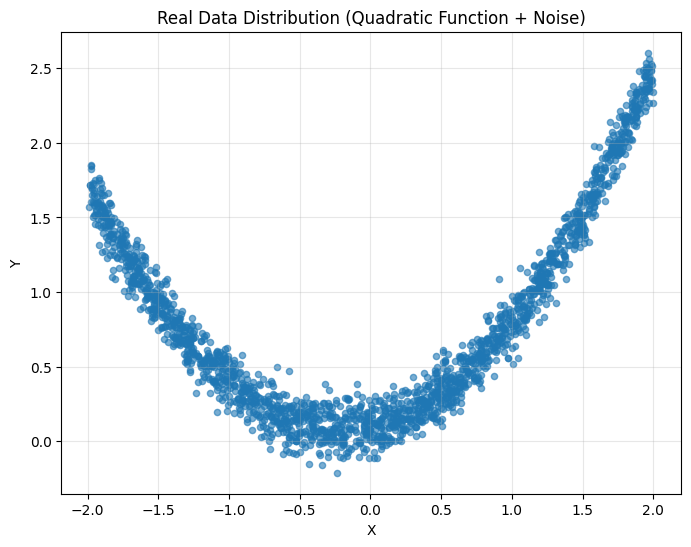

Initializing GAN...
Starting training...
Epoch [1000/10000], D_loss: 1.3957, G_loss: 0.6862
Epoch [2000/10000], D_loss: 1.3805, G_loss: 0.6878
Epoch [3000/10000], D_loss: 1.3949, G_loss: 0.6697
Epoch [4000/10000], D_loss: 1.3861, G_loss: 0.7037
Epoch [5000/10000], D_loss: 1.3864, G_loss: 0.6937
Epoch [6000/10000], D_loss: 1.3866, G_loss: 0.6932
Epoch [7000/10000], D_loss: 1.3864, G_loss: 0.6926
Epoch [8000/10000], D_loss: 1.3864, G_loss: 0.6931
Epoch [9000/10000], D_loss: 1.3863, G_loss: 0.6927
Epoch [10000/10000], D_loss: 1.3864, G_loss: 0.6930
Training completed! Plotting results...


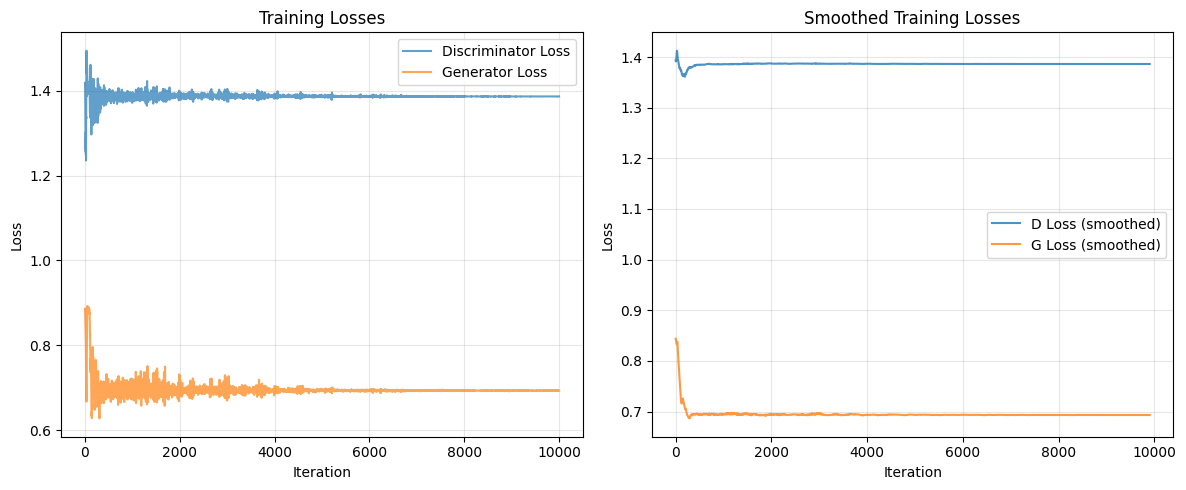

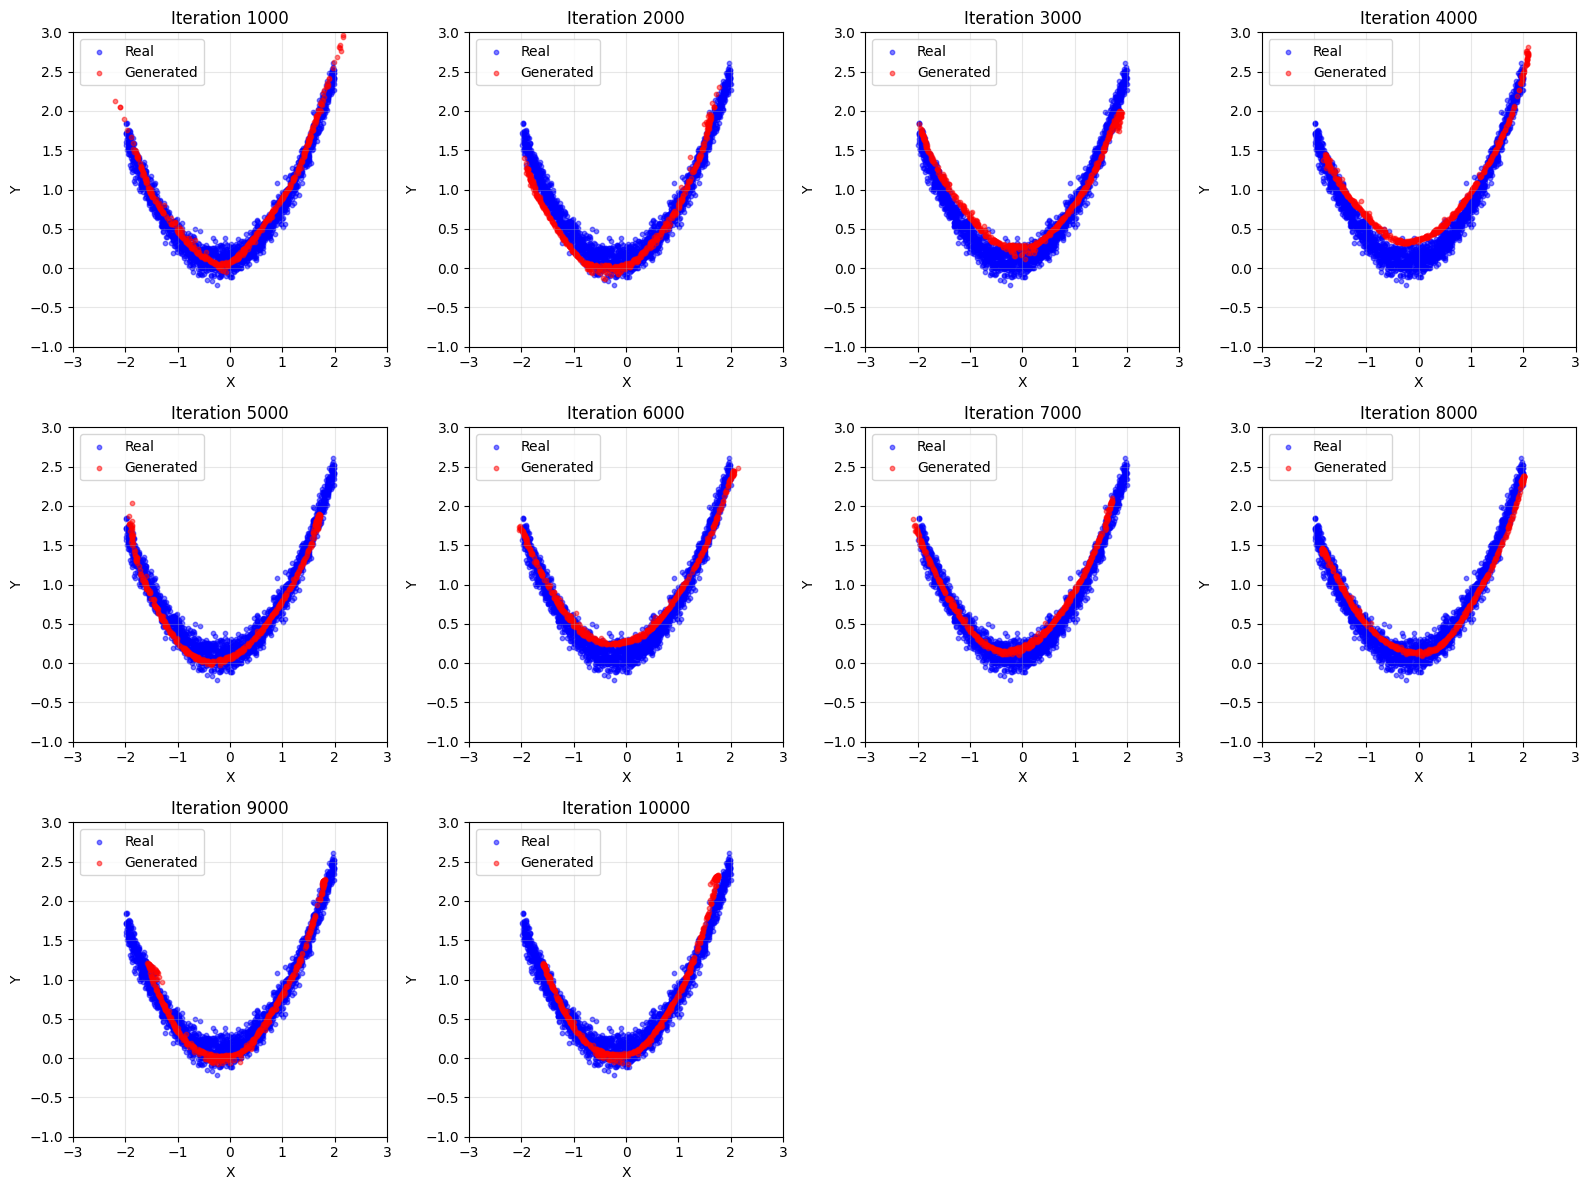

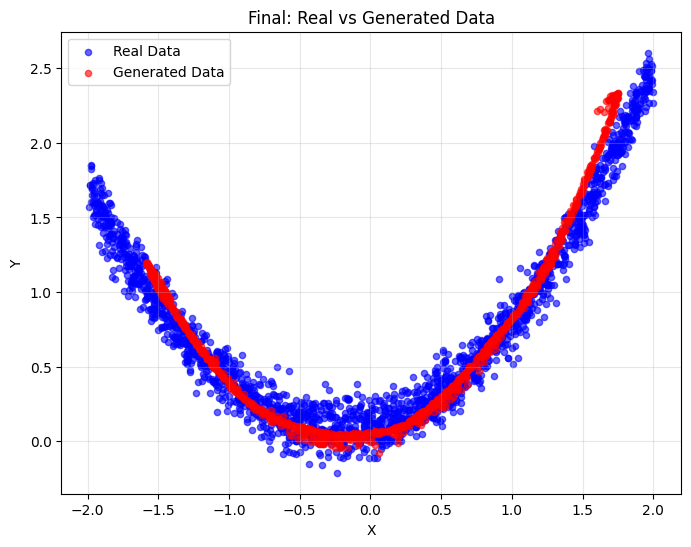

GAN training and visualization completed!


In [ ]:

print("Generating training data...")
data_gen = DataGenerator(n_samples=2000, noise_std=0.1)
real_data = data_gen.generate_data()

plt.figure(figsize=(8, 6))
real_np = real_data.cpu().numpy()
plt.scatter(real_np[:, 0], real_np[:, 1], alpha=0.6, s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Real Data Distribution (Quadratic Function + Noise)')
plt.grid(True, alpha=0.3)
plt.show()

generator_params = {
    'input_dim': 2,
    'hidden_dim1': 64,
    'hidden_dim2': 32,
    'output_dim': 2
}

discriminator_params = {
    'input_dim': 2,
    'hidden_dim1': 64,
    'hidden_dim2': 32,
    'hidden_dim3': 2
 }

print("Initializing GAN...")
gan = SimpleGAN(generator_params, discriminator_params, lr=0.001)

print("Starting training...")
gan.train(real_data, epochs=10000, batch_size=64, print_interval=1000, plot_interval=1000)

print("Training completed! Plotting results...")

gan.plot_losses()

gan.plot_samples_progression()

gan.plot_final_comparison()

print("GAN training and visualization completed!")
